In [12]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 

####################you will need to change some paths here!#####################
#list of input files
filename_origin='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info.nc'
# output files
filename_origin_out='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info_envdata'


In [2]:
ds_bird = xr.open_dataset(filename_origin)
ds_bird['time']=ds_bird.time64
ds_bird['lon'] = (ds_bird['lon'] + 180) % 360 - 180

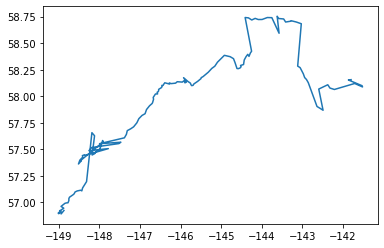

In [3]:
plt.plot(ds_bird.lon[0,:],ds_bird.lat[0,:])

In [13]:
def get_data():
    
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
#    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
#    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
#    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
#    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sat_data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
#    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
#    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #get bathymetry from ETOPO1
    fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
    ds = xr.open_dataset(fname_topo)
    ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
    tem = ds_topo.z.attrs
    tem['var_name']='etopo_depth'
    ds_topo.z.attrs=tem
    
    ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-DAILY')
    for var in ds_color:
        if not var=='chlor_a':
            ds_color = ds_color.drop(var)
    #ds_color = ds_color.sortby(ds_color.lat)

    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
               'color':ds_color,
              'topo':ds_topo}
#    clim_dict={'aviso_clim':ds_aviso_clim,
#               'wnd_clim':ds_ccmp_clim,
#               'sst_clim':ds_sst_clim}
  
    return data_dict#,clim_dict

data = get_data()
#data,clim = get_data()

In [7]:
##color
input_data = 'color'
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if not name==input_data:
        continue
    print('name',name)   
    for var in ds_data:
        var_tem=var #ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        for j in range(10):#ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(4,'D'), ds_bird.time[i,j]+np.timedelta64(4,'D')
            lat1,lat2=ds_bird.lat[i,j]+.5,ds_bird.lat[i,j]-.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
#            tem = ds_data.sel(time=str(ds_bird.time[i,j].data)[0:10],method='nearest')
            tem = ds_data.sel(time=slice(t1,t2)).mean(dim='time',keep_attrs=True,skip_nan=True)
            tem = tem.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=var #ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i,ilen_bird1)
    #df_bird = ds_bird.to_dataframe()
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')


name color
var chlor_a
0 765
1 765
2 765
3 765
4 765
5 765
6 765
7 765
8 765
9 765
10 765
11 765
12 765
13 765
14 765
15 765
16 765
17 765
18 765
19 765
20 765
21 765
22 765
23 765
24 765
25 765
26 765
27 765
28 765
29 765
30 765
31 765
32 765
33 765
34 765
35 765
36 765
37 765
38 765
39 765
40 765
41 765
42 765
43 765
44 765
45 765
46 765
47 765
48 765
49 765
50 765
51 765
52 765
53 765
54 765
55 765
56 765
57 765
58 765
59 765
60 765
61 765
62 765
63 765
64 765
65 765
66 765
67 765
68 765
69 765
70 765
71 765
72 765
73 765
74 765
75 765
76 765
77 765
78 765
79 765
80 765
81 765
82 765
83 765
84 765
85 765
86 765
87 765
88 765
89 765
90 765


RuntimeError: NetCDF: Access failure

In [18]:
str(t1.data)[0:10]

'1997-09-11'

In [ ]:
#ds_data=data[name]
tem = ds_data.sel(time=slice(str(t1.data)[0:10],str(t2.data)[0:10]))
tem = tem.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))

In [ ]:
tem

In [ ]:
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
    if name=='color':
        continue
    #if not name==input_data:
    #    continue
    print('name',name)   
    for var in ds_data:
        var_tem=var #ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        for j in range(10):#ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(24,'h'), ds_bird.time[i,j]+np.timedelta64(24,'h')
            lat1,lat2=ds_bird.lat[i,j]-.5,ds_bird.lat[i,j]+.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
            tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(time=ds_bird.time[i,j],lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i,ilen_bird1)
    #df_bird = ds_bird.to_dataframe()
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')
ds_bird.to_netcdf(filename_origin_out+'all'+'.nc')


In [ ]:
import glob 
#put it all together and create a csv file
print(filename_origin_out)
#filename = glob.glob('f:/data/project_data/NASA_biophysical/collocated_data/'+filename_origin_out+'*.nc')
filename = glob.glob('f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info_envdata*.nc')
filename = filename[1:]
filename



In [ ]:
print(filename[0])
ds = xr.open_dataset(filename[0])
for iname in range(1,len(filename)):
    print(filename[iname])
    ds2 = xr.open_dataset(filename[iname])
    for var in ds2:
        if not var in ds:
            ds[var]=ds2[var]
                
ds.to_netcdf(filename_origin_out+'all'+'.nc')
df_bird = ds.to_dataframe()
df_bird.to_csv(filename_origin_out+'all'+'.csv')


# trying to do topo 
- but lots of nan becuase of array construct

In [ ]:
ds_topo=data['topo']
new_lat = xr.DataArray(ds_bird.lat.values, dims=('new_dim1','new_dims2')).fillna(0)
new_lon = xr.DataArray(ds_bird.lon.values, dims=('new_dim1','new_dims2')).fillna(0)
tem2 = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')
ds_bird['ETOPO_depth'] = xr.DataArray(tem2.data, 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
ds_bird['ETOPO_depth']=np.where(np.isnan(ds_bird.lat),np.nan,ds_bird['ETOPO_depth'])


In [ ]:
ds_bird

In [ ]:
##topo
ds_topo=data['topo']
temlat = ds_bird.lat
temlon = ds_bird.lon
temlat = temlat.fillna(0)
temlon = temlon.fillna(0)
tem2=ds_topo.z.interp(lat=temlat,lon=temlon,method='nearest') 
#ds_bird['ETOPO_depth']